In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
from transformers import AutoModelForCausalLM, AutoTokenizer, AutoModel, \
  BitsAndBytesConfig, GPTQConfig
import os

while "notebooks" in os.getcwd():
    os.chdir("..")

from time import time
from tqdm import tqdm
import torch
from langdetect import detect
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from huggingface_hub import notebook_login
from datasets import load_dataset
import math
from typing import List, Optional, Tuple, Union
from torch import nn
from tqdm import tqdm
from IPython.display import clear_output
import warnings
warnings.filterwarnings("ignore")
from copy import deepcopy
import gc
from sklearn.metrics import  roc_auc_score, average_precision_score

from src.utils import get_context_length, rolling_mean, \
    convert_to_json, score_json, get_text_whithin_braces  

from src.attention_saver import Mistral7BAttentionSaver
from src.influence.influence import Influence
tqdm.pandas()


import scienceplots
plt.style.use(['science','no-latex', 'grid'])

In [5]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16
)

tokenizer = AutoTokenizer.from_pretrained(
    "mistralai/Mistral-7B-Instruct-v0.1",
    cache_dir = "/Data"    
)


base_model = AutoModelForCausalLM.from_pretrained(
    "mistralai/Mistral-7B-Instruct-v0.1",
    quantization_config = quantization_config,
    device_map="auto",
    attn_implementation="eager",
    cache_dir = "/Data"
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
dataset = load_dataset("TheBritishLibrary/blbooks", "1510_1699", cache_dir = "/Data")['train']\
    .to_pandas()\
    [["record_id", "title", "text", "pg", "all_names", "Language_1"]]

dataset['context_length'] = dataset['text'].progress_apply(get_context_length, tokenizer=tokenizer)
dataset.record_id.nunique()
all_df = []

for book_id, df in dataset.groupby('record_id'):
    df['text'] = df['text'].cumsum()
    df['context_length'] = df['context_length'].cumsum()

    all_df.append(df)
books = pd.concat(all_df)
np.random.seed(42)
book_ids = np.random.choice(books.record_id.unique(), replace= False, size = 300)

100%|██████████| 51982/51982 [00:39<00:00, 1327.63it/s]


In [7]:
SCHEMA = '''{
    "title": "title of the story (string)", 
    "genre": string, 
    "characters": [{"name": string, "description": string. If not available set it to none} (one dict per character)], 
    "author": "the author of the story. If not available, set it to None", 
    "summary": "a brief summary of the story. Do not write more than 50 words",
    "date": "when the story was released (string)",
    "scenery": "where the story takes place (string)",
}
'''

TEMPLATE = '''
You are an assistant designed to provide information in JSON format. 
I will give you a story, and you need to extract and return specific details from the story. 
Do not output anything else than the JSON.

Your response should follow exactly this template: 

<schema>
{schema}
</schema>

{content}

'''

In [8]:
mask = books.record_id.isin(book_ids)
selected_books = books[mask].query("context_length <4000 & context_length > 500")

In [9]:
selected_books['prompt'] = selected_books\
    ['text']\
    .apply(lambda x: TEMPLATE.format(content = x, schema = SCHEMA))


sentence = "Your response should follow exactly this template:"
selected_books['instruction'] = sentence


df1= deepcopy(selected_books.query("context_length > 3500").iloc[1])

selected_books['prompt'] = selected_books\
    ['text']\
    .apply(lambda x: TEMPLATE.replace(sentence, sentence.upper()).format(content = x, schema = SCHEMA))

selected_books['instruction'] = sentence.upper()

df2 = deepcopy(selected_books.query("context_length > 3500").iloc[1])

selected_books = pd.concat([df1,df2], axis = 1).T

In [10]:
selected_books

,record_id,title,text,pg,all_names,Language_1,context_length,prompt,instruction
28951,000109780,"She Ventures, and He Wins. A comedy ... Writen...","SHE VENTURES, AND-: H E W I N S. # n VL • %& f...",16,None,English,3582,\nYou are an assistant designed to provide inf...,Your response should follow exactly this templ...
28951,000109780,"She Ventures, and He Wins. A comedy ... Writen...","SHE VENTURES, AND-: H E W I N S. # n VL • %& f...",16,None,English,3582,\nYou are an assistant designed to provide inf...,YOUR RESPONSE SHOULD FOLLOW EXACTLY THIS TEMPL...


## Influence (ours)

In [11]:
N_LAYERS = 32
influence = Influence(
    base_model,
    tokenizer,
    N_LAYERS
)
results_raw = influence(
    selected_books.reset_index(),
    0,
    instruction_in_text=True,
    instruction_col="instruction",
    text_col="prompt"
)

53 74
Forward propagation on instruction = YOUR RESPONSE SHOULD FOLLOW EXACTLY THIS TEMPLATE:. Index = 1
Influence tokens : 53 to 74
Studying influence to 'YOUR RESPONSE SHOULD FOLLOW EXACTLY THIS TEMPLATE:'
Finished forward step in 8.273887872695923 s


100%|██████████| 32/32 [00:00<00:00, 94.45it/s]


Passing tensors to CPU...


In [12]:

results_delta = influence(
    selected_books.iloc[[0]].reset_index(),
    1,
    instruction_in_text=True,
    instruction_col="instruction",
    text_col="prompt"
)

53 61
Forward propagation on instruction = Your response should follow exactly this template:. Index = 0
Influence tokens : 53 to 61
Studying influence to 'Your response should follow exactly this template:'
Finished forward step in 7.682507038116455 s


100%|██████████| 32/32 [00:00<00:00, 83.56it/s]


Passing tensors to CPU...


In [13]:

results_delta2 = influence(
    selected_books.iloc[[0]].reset_index(),
    2,
    instruction_in_text=True,
    instruction_col="instruction",
    text_col="prompt"
)

53 61
Forward propagation on instruction = Your response should follow exactly this template:. Index = 0
Influence tokens : 53 to 61
Studying influence to 'Your response should follow exactly this template:'
Finished forward step in 7.36484169960022 s


100%|██████████| 32/32 [00:00<00:00, 94.89it/s]


Passing tensors to CPU...


In [11]:

results_delta.keys()

dict_keys([(28951, 'Your response should follow exactly this template:')])

In [12]:
results_delta.keys()

dict_keys([(28951, 'Your response should follow exactly this template:')])

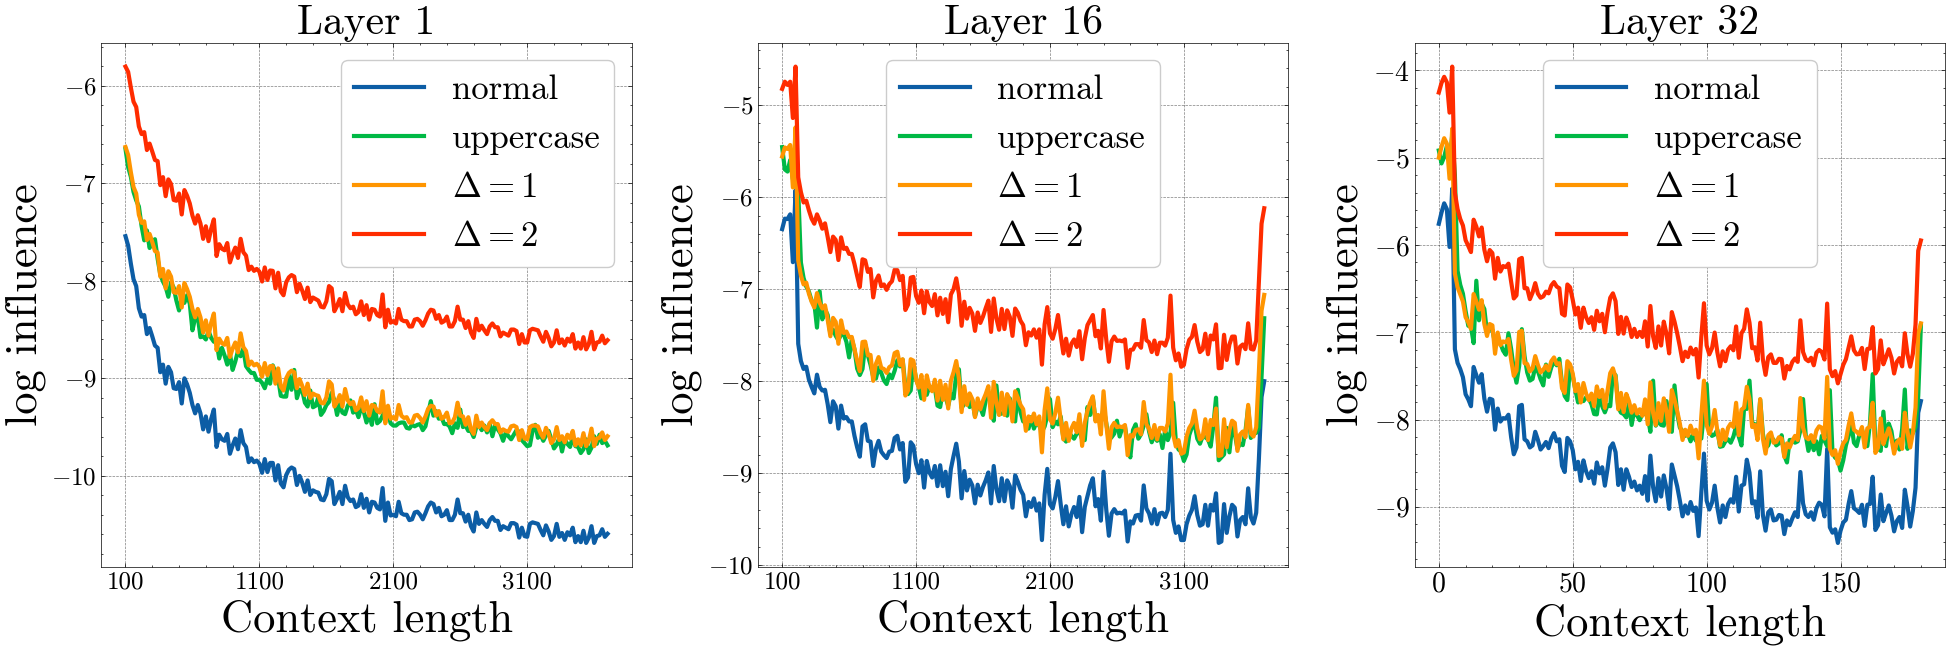

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 7))
plt.rc("font", size = 20)

for id, ((text_id, instruction), values) in enumerate(results_raw.items()):
    influences = values['influences']
    axes[0].plot(
        torch.log(rolling_mean(influences[0], 20)[5:]),
        label = "uppercase" if instruction.isupper() else "normal",
        linewidth = 3
    )


    axes[1].plot(
        torch.log(rolling_mean(influences[15], 20)[5:]),
        label = "uppercase" if instruction.isupper() else "normal",
        linewidth = 3
    )


    axes[2].plot(
        torch.log(rolling_mean(influences[31], 20)[5:]),
        label = "uppercase" if instruction.isupper() else "normal",
        linewidth = 3
    )

axes[0].plot(
    torch.log(
        
        rolling_mean(
            results_delta[list(results_delta.keys())[0]]\
                ['influences']\
                [0],
            20
        )[5:]
    ), 
    linewidth = 3,
    label = r"$\Delta = 1$"
)

axes[1].plot(
    torch.log(
        
        rolling_mean(
            results_delta[list(results_delta.keys())[0]]\
                ['influences']\
                [15],
            20
        )[5:]
    ), 
    linewidth = 3,
    label = r"$\Delta = 1$"
)

axes[2].plot(
    torch.log(
        
        rolling_mean(
            results_delta[list(results_delta.keys())[0]]\
                ['influences']\
                [31],
            20
        )[5:]
    ), 
    linewidth = 3,
    label = r"$\Delta = 1$"
)

axes[0].plot(
    torch.log(
        
        rolling_mean(
            results_delta2[list(results_delta.keys())[0]]\
                ['influences']\
                [0],
            20
        )[5:]
    ), 
    linewidth = 3,
    label = r"$\Delta = 2$"
)

axes[1].plot(
    torch.log(
        
        rolling_mean(
            results_delta2[list(results_delta.keys())[0]]\
                ['influences']\
                [15],
            20
        )[5:]
    ), 
    linewidth = 3,
    label = r"$\Delta = 2$"
)

axes[2].plot(
    torch.log(
        
        rolling_mean(
            results_delta2[list(results_delta.keys())[0]]\
                ['influences']\
                [31],
            20
        )[5:]
    ), 
    linewidth = 3,
    label = r"$\Delta = 2$"
)


label_fontsize = 32
legend_fontsize = 25
tick_fontsize = 20
title_fontsize = 30

axes[0].legend(prop= {"size" : legend_fontsize})
axes[1].legend(prop= {"size" : legend_fontsize})
axes[2].legend(prop= {"size" : legend_fontsize})

axes[0].set_title("Layer 1", fontsize = title_fontsize)
axes[1].set_title("Layer 16", fontsize =  title_fontsize)
axes[2].set_title("Layer 32", fontsize =  title_fontsize)
# axes[2].set_title("Layer 32")

axes[0].grid(True)
axes[1].grid(True)
axes[2].grid(True)


axes[0].set_xlabel("Context length", fontsize =  label_fontsize)
axes[0].set_ylabel("log influence", fontsize =  label_fontsize )

axes[1].set_xlabel("Context length", fontsize =  label_fontsize )
axes[1].set_ylabel("log influence", fontsize =  label_fontsize )

axes[2].set_xlabel("Context length", fontsize =  label_fontsize  )
axes[2].set_ylabel("log influence", fontsize =  label_fontsize  )

xticks = axes[0].get_xticks()
new_xticks = xticks * 20 + 100

# Set the new x-tick labels
axes[0].set_xticklabels(new_xticks.astype(int))
axes[1].set_xticklabels(new_xticks.astype(int))
axes[0].tick_params(axis='both', which='major', labelsize=18)
axes[1].tick_params(axis='both', which='major', labelsize=18)


plt.tight_layout()
plt.savefig("img/influence_ctx_len_delta.pdf")

In [9]:
groupby_text_idx = {}
for (text_idx, instruction) in results_raw.keys():
    if not text_idx in groupby_text_idx:
        groupby_text_idx[text_idx] = {}

    if not instruction in groupby_text_idx[text_idx]:
        groupby_text_idx[text_idx][instruction] = {}

    for layer in range(32):
        groupby_text_idx[text_idx][instruction][layer] = results_raw\
            [(text_idx, instruction)]\
            ['influences']\
            [layer]
        


In [12]:
x = pd.DataFrame(groupby_text_idx)
x.index.name = 'instruction'
melted_influences = pd.melt(
    x.reset_index(), 
    id_vars=['instruction'],
    value_name = 'influence',
    var_name = 'text_idx'    
).dropna()

melted_influences


,instruction,text_idx,influence
0,Your response should follow exactly this templ...,17579,"{0: [tensor(0., dtype=torch.float16), tensor(0..."
1,Your response should follow exactly this templ...,32131,"{0: [tensor(0., dtype=torch.float16), tensor(0..."
2,Your response should follow exactly this templ...,18986,"{0: [tensor(0., dtype=torch.float16), tensor(0..."
3,Your response should follow exactly this templ...,31526,"{0: [tensor(0., dtype=torch.float16), tensor(0..."
4,Your response should follow exactly this templ...,29396,"{0: [tensor(0., dtype=torch.float16), tensor(0..."
...,...,...,...
195,Your response should follow exactly this templ...,30146,"{0: [tensor(0., dtype=torch.float16), tensor(0..."
196,Your response should follow exactly this templ...,6125,"{0: [tensor(0., dtype=torch.float16), tensor(0..."
197,Your response should follow exactly this templ...,34875,"{0: [tensor(0., dtype=torch.float16), tensor(0..."
198,Your response should follow exactly this templ...,26632,"{0: [tensor(0., dtype=torch.float16), tensor(0..."


In [8]:
cols = selected_books.columns\
    .difference(melted_influences.columns)

melted_influences = pd.merge(
    melted_influences,
    selected_books[cols],
    left_on = ['text_idx',],
    right_index=True
)

NameError: name 'melted_influences' is not defined

In [18]:
melted_influences.to_pickle("data/influences/json/influence_json.pkl")

In [3]:
melted_influences = pd.read_pickle("data/influences/json/influence_json2.pkl")

In [4]:
melted_influences

,instruction,text_idx,influence,Language_1,all_names,context_length,pg,prompt,record_id,text,title
0,Your response should follow exactly this templ...,46893,"{0: [tensor(0., dtype=torch.float16), tensor(0...",English,"Motteux, Peter Anthony, 1660-1718 [person] ; S...",3997,18,\nYou are an assistant designed to provide inf...,003418042,"f!; ' 'V^- d »* -w . , THE Princefsof^ Parma. ...",The Princess of Parma. A tragedy [in five acts...
1,Your response should follow exactly this templ...,3841,"{0: [tensor(0., dtype=torch.float16), tensor(0...",English,"Losa, Andres de la [person]",3995,18,\nYou are an assistant designed to provide inf...,002263347,V E RDADERO ENTRE T E NIMl E N T O del Chrifti...,"Verdadero Entretenimiento del Christiano, en e..."
2,Your response should follow exactly this templ...,34764,"{0: [tensor(0., dtype=torch.float16), tensor(0...",English,None,3994,14,\nYou are an assistant designed to provide inf...,001145182,"AN ENQ.UIRY AFTER RELIGION: OR, A View of thtt...",An Enquiry after Religion: or a view of the Id...
3,Your response should follow exactly this templ...,19174,"{0: [tensor(0., dtype=torch.float16), tensor(0...",English,"Fletcher, John, dramatist [person]",3994,17,\nYou are an assistant designed to provide inf...,001253007,THE ELDER BROTHER A COMEDIE. A#ed at the TSlac...,"The Elder Brother. A comedie, [in five acts an..."
4,Your response should follow exactly this templ...,23159,"{0: [tensor(0., dtype=torch.float16), tensor(0...",English,"Heywood, Thomas, dramatist [person]",3992,15,\nYou are an assistant designed to provide inf...,001677342,"The V Vife- woman » .1 i Of HOQJDOK, A COMEDIE...",The Wise-woman of Hogsdon. A Comedie [in five ...
...,...,...,...,...,...,...,...,...,...,...,...
2241,Your response should follow exactly this templ...,43900,"{0: [tensor(0., dtype=torch.float16), tensor(0...",English,"Cleveland, John, poet [person]",506,7,\nYou are an assistant designed to provide inf...,002252848,THE CHARACTER Of & London -Diurnall: With' fev...,The Character of a London Diurnall [By J. Clea...
2242,Your response should follow exactly this templ...,5811,"{0: [tensor(0., dtype=torch.float16), tensor(0...",English,"England [organisation] ; Adams, Mary, active 1...",505,11,\nYou are an assistant designed to provide inf...,000000874,Q^u'^rtfLspA WARNING T O TH E INHABITANTS OF E...,"A Warning to the inhabitants of England, and L..."
2243,Your response should follow exactly this templ...,47662,"{0: [tensor(0., dtype=torch.float16), tensor(0...",English,None,503,8,\nYou are an assistant designed to provide inf...,003678244,"FVIMVS TROES JEneid. z. THE TRVE TROIANES, Bei...","Fuimus Troes. Æneid. 2. The true Troianes, bei..."
2244,Your response should follow exactly this templ...,49176,"{0: [tensor(0., dtype=torch.float16), tensor(0...",English,"Chapman, George, approximately 1559-1634 [person]",502,9,\nYou are an assistant designed to provide inf...,000660920,THE VViddovvesTearcs *a Comedie. A$ it was oft...,The Widdowes Teares. A comedie ... Written by ...


In [9]:
generated_text = pd.read_parquet("data/study-04-json/05/delta=0.0.parquet")

generated_text['generated_text'] = generated_text['generated_text']\
        .apply(lambda x: x.split('[/INST]')[1])
        
generated_text['generated_braces'] = generated_text['generated_text']\
    .apply(get_text_whithin_braces)

generated_text['generated_json'] = generated_text['generated_braces'].apply(convert_to_json)

generated_text['score'] = generated_text['generated_json'].apply(score_json)

In [10]:
influence_score_df = pd.merge(
    melted_influences,
    generated_text,
    left_on= "text_idx",
    right_index=True
    
)

In [11]:
def get_avg_influence_over_layers(influences):
    layers_influences = torch.stack(list(influences.values()))
    return layers_influences.mean(dim = 0)

influence_score_df['avg_influence'] = influence_score_df['influence'].apply(get_avg_influence_over_layers)

influence_score_df['last_token_avg_influence'] = influence_score_df['avg_influence']\
    .apply(lambda x: x[-5:].mean().item())

In [12]:
influence_score_df['last_layer_influence'] = influence_score_df['influence'].apply(lambda x : x[31][-5:].mean().item())

In [19]:
influence_score_df["context_length_bins"]= pd.cut(
    influence_score_df['context_length_x'],
    range(0, 5000, 1500)
)

In [21]:
influence_score_df.columns

Index(['instruction', 'text_idx', 'influence', 'Language_1', 'all_names',
       'context_length_x', 'pg', 'prompt', 'record_id', 'text', 'title',
       'generated_text', 'original_text', 'schema', 'context_length_y',
       'book_id', 'generated_braces', 'generated_json', 'score',
       'avg_influence', 'last_token_avg_influence', 'last_layer_influence',
       'context_length_bins'],
      dtype='object')

In [20]:
influence_score_df

,instruction,text_idx,influence,Language_1,all_names,context_length_x,pg,prompt,record_id,text,...,schema,context_length_y,book_id,generated_braces,generated_json,score,avg_influence,last_token_avg_influence,last_layer_influence,context_length_bins
0,Your response should follow exactly this templ...,46893,"{0: [tensor(0., dtype=torch.float16), tensor(0...",English,"Motteux, Peter Anthony, 1660-1718 [person] ; S...",3997,18,\nYou are an assistant designed to provide inf...,003418042,"f!; ' 'V^- d »* -w . , THE Princefsof^ Parma. ...",...,"{\n ""title"": ""title of the story (string)"",...",3997,003418042,"{\n""title"": ""The Princefs of Parma"",\n""genre"":...",None,0.000000,"[tensor(0., dtype=torch.float16), tensor(0., d...",0.001491,0.003338,"(3000, 4500]"
1,Your response should follow exactly this templ...,3841,"{0: [tensor(0., dtype=torch.float16), tensor(0...",English,"Losa, Andres de la [person]",3995,18,\nYou are an assistant designed to provide inf...,002263347,V E RDADERO ENTRE T E NIMl E N T O del Chrifti...,...,"{\n ""title"": ""title of the story (string)"",...",3995,002263347,"{\n""title"": ""El Quarto de la Fortuna"",\n""genre...",None,0.000000,"[tensor(0., dtype=torch.float16), tensor(0., d...",0.001458,0.003254,"(3000, 4500]"
2,Your response should follow exactly this templ...,34764,"{0: [tensor(0., dtype=torch.float16), tensor(0...",English,None,3994,14,\nYou are an assistant designed to provide inf...,001145182,"AN ENQ.UIRY AFTER RELIGION: OR, A View of thtt...",...,"{\n ""title"": ""title of the story (string)"",...",3994,001145182,"{\n""title"": ""A View of Religion"",\n""genre"": ""R...",None,0.000000,"[tensor(0., dtype=torch.float16), tensor(0., d...",0.002087,0.004486,"(3000, 4500]"
3,Your response should follow exactly this templ...,19174,"{0: [tensor(0., dtype=torch.float16), tensor(0...",English,"Fletcher, John, dramatist [person]",3994,17,\nYou are an assistant designed to provide inf...,001253007,THE ELDER BROTHER A COMEDIE. A#ed at the TSlac...,...,"{\n ""title"": ""title of the story (string)"",...",3994,001253007,"{\n""title"": ""The Elder Brother"",\n""genre"": ""co...","{'title': 'The Elder Brother', 'genre': 'comed...",0.714286,"[tensor(0., dtype=torch.float16), tensor(0., d...",0.001417,0.003151,"(3000, 4500]"
4,Your response should follow exactly this templ...,23159,"{0: [tensor(0., dtype=torch.float16), tensor(0...",English,"Heywood, Thomas, dramatist [person]",3992,15,\nYou are an assistant designed to provide inf...,001677342,"The V Vife- woman » .1 i Of HOQJDOK, A COMEDIE...",...,"{\n ""title"": ""title of the story (string)"",...",3992,001677342,"{\n""title"": ""The Wife-woman of Hogfdon"",\n""gen...","{'title': 'The Wife-woman of Hogfdon', 'genre'...",0.714286,"[tensor(0., dtype=torch.float16), tensor(0., d...",0.001543,0.003504,"(3000, 4500]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2241,Your response should follow exactly this templ...,43900,"{0: [tensor(0., dtype=torch.float16), tensor(0...",English,"Cleveland, John, poet [person]",506,7,\nYou are an assistant designed to provide inf...,002252848,THE CHARACTER Of & London -Diurnall: With' fev...,...,"{\n ""title"": ""title of the story (string)"",...",506,002252848,"{\n""title"": ""London-Diurnall"",\n""genre"": ""Poem...","{'title': 'London-Diurnall', 'genre': 'Poem', ...",1.000000,"[tensor(0., dtype=torch.float16), tensor(0., d...",0.002441,0.004921,"(0, 1500]"
2242,Your response should follow exactly this templ...,5811,"{0: [tensor(0., dtype=torch.float16), tensor(0...",English,"England [organisation] ; Adams, Mary, active 1...",505,11,\nYou are an assistant designed to provide inf...,000000874,Q^u'^rtfLspA WARNING T O TH E INHABITANTS OF E...,...,"{\n ""title"": ""title of the story (string)"",...",505,000000874,"{\n""title"": ""A WARNING TO THE INHABITANTS OF E...",{'title': 'A WARNING TO THE INHABITANTS OF ENG...,1.000000,"[tensor(0., dtype=torch.float16), tensor(0., d...",0.002096

In [28]:
def get_auc_per_context_len(x, column : str):
    return roc_auc_score(x['score']>0, x[column])

auc_influence = influence_score_df.groupby("context_length_bins")\
    .apply(get_auc_per_context_len, column = 'last_token_avg_influence')\
    .reset_index()

auc_influence['metric'] = 'influence'

auc_context_length = influence_score_df.groupby("context_length_bins")\
    .apply(get_auc_per_context_len, column = 'context_length_x')\
    .reset_index()

auc_context_length['metric'] = 'context_length'

In [29]:
pd.concat([auc_influence, auc_context_length])

,context_length_bins,0,metric
0,"(0, 1500]",0.495808,influence
1,"(1500, 3000]",0.498358,influence
2,"(3000, 4500]",0.394023,influence
0,"(0, 1500]",0.441103,context_length
1,"(1500, 3000]",0.462578,context_length
2,"(3000, 4500]",0.377334,context_length


In [31]:
target, probas =  influence_score_df['score'] > 0, influence_score_df['last_token_avg_influence']

In [32]:
roc_auc_score(target, probas)

0.6291827640481593

In [33]:
target.corr(probas)

0.23193026777036777

<Axes: xlabel='last_layer_influence', ylabel='score'>

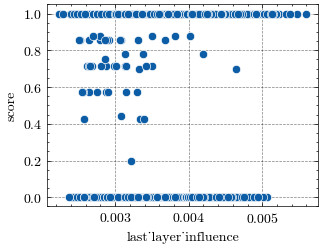

In [34]:
sns.scatterplot(
    influence_score_df,
    x = 'last_layer_influence',
    y= 'score'
)

In [37]:
influence_score_df['layer 0'] = influence_score_df['influence'].apply(lambda x : x[0])
influence_score_df['layer 15'] = influence_score_df['influence'].apply(lambda x : x[15])
influence_score_df['layer 31'] = influence_score_df['influence'].apply(lambda x : x[31])

In [41]:
samples = influence_score_df.query("context_length_x > 3000")\
    .sample(5, random_state=42)

In [44]:
sorted(samples.index)

[70, 131, 400, 507, 541]

In [69]:
def rolling(fn : callable, X, slice, axis):
    '''Return sum of a rolling slice on the tensor over a specified axis'''
    PaddedX = torch.nn.functional.pad(X, ([0,0,]*axis + [slice-1,0]))
    XView = PaddedX.unfold( len(X.shape) -1-axis, slice, 1)
    Xroll =   fn(XView, dim=-1, )
    return Xroll

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 2.8789e-05, 2.8551e-05,
        2.8849e-05], dtype=torch.float16)

In [63]:
rolling_mean(influence_0, 20).shape

torch.Size([159])

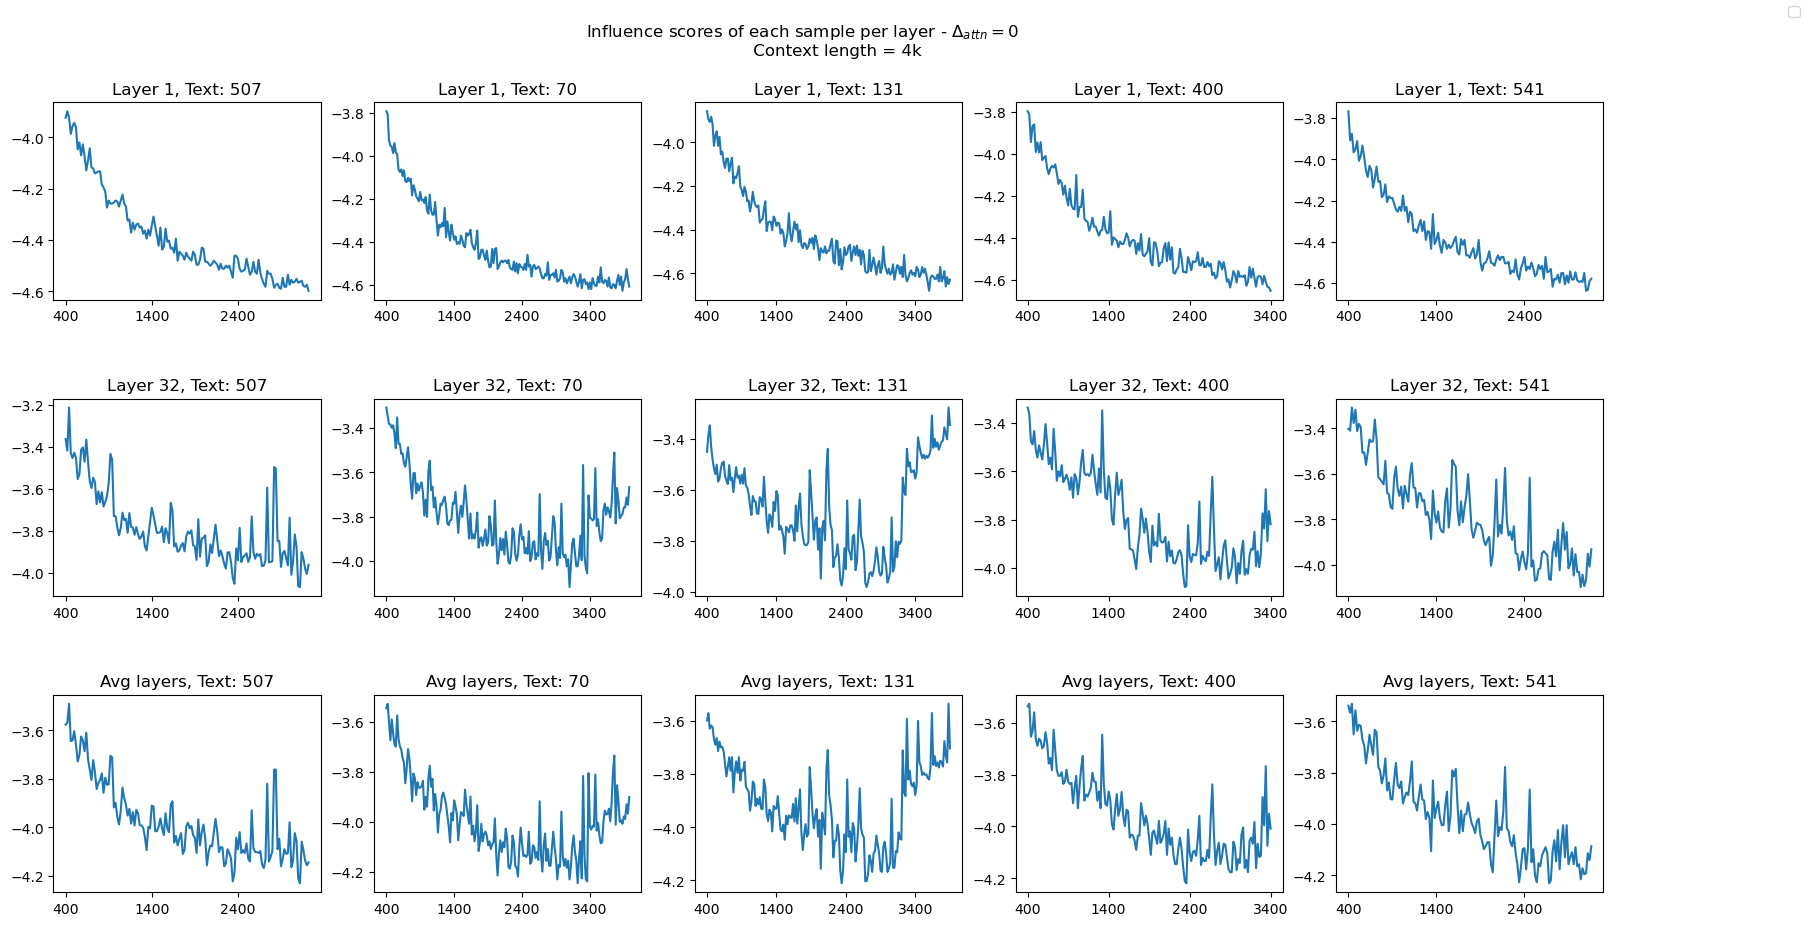

In [75]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(20, 10))

text_id_keymap = {k: i for (i,k) in enumerate(sorted(samples.index))}
layer_id_keymap = {0:0, 15: 1, 31: 2}


for id, (text_id, res) in enumerate((samples).iterrows()):
        influence_0 = res['layer 0']
        influence_31 = res['layer 31']
        avg_influence = res['avg_influence']


        axes[0][id].plot(
            torch.log10(rolling_mean(influence_0, 20)[20:]),
            # label = instruction,
        )


        axes[1][id].plot(
            torch.log10(rolling_mean(influence_31, 20)[20:]),
            # label = instruction,
        )


        axes[2][id].plot(
            torch.log10(rolling_mean(avg_influence, 20)[20:]),
            # label = instruction,
        )

        axes[0][id].set_title(f"Layer 1, Text: {text_id}")
        axes[1][id].set_title(f"Layer 32, Text: {text_id}")
        axes[2][id].set_title(f"Avg layers, Text: {text_id}")

        xticks = axes[0][id].get_xticks()
        new_xticks = xticks * 20 + 400

        # Set the new x-tick labels
        axes[0][id].set_xticklabels(new_xticks.astype(int))
        axes[1][id].set_xticklabels(new_xticks.astype(int))
        axes[2][id].set_xticklabels(new_xticks.astype(int))

      
            # axes[layer_id][id].set_title(f"Layer {layer}, Text: {text_id}")
            # axes[layer_id][id].grid(True)

            # xticks = axes[layer_id][id].get_xticks()
            # new_xticks = xticks * 20 + 400

            # # Set the new x-tick labels
            # axes[layer_id][id].set_xticklabels(new_xticks.astype(int))
            # axes[layer_id][id].set_xlabel("context length")
            # axes[layer_id][id].set_ylim([-10, -5])
handles, labels = axes[-1][-1].get_legend_handles_labels()

fig.suptitle(r'''Influence scores of each sample per layer - $\Delta_{attn} = 0$ 
             Context length = 4k''')


fig.subplots_adjust(top=0.9)
fig.subplots_adjust(hspace=0.5)

fig.legend(handles, labels)


In [48]:
res

instruction                 Your response should follow exactly this templ...
text_idx                                                                18895
influence                   {0: [tensor(0., dtype=torch.float16), tensor(0...
Language_1                                                            English
all_names                   Brome, Richard, -approximately 1652 [person] ;...
context_length_x                                                         3107
pg                                                                         16
prompt                      \nYou are an assistant designed to provide inf...
record_id                                                           001253024
text                        MONSIE VR THOMAS A COMEDY Acted at the Private...
title                       Monsieur Thomas, a comedy [in five acts and in...
generated_text               <schema>\n{\n"title": "Monsieur Thomas, A Com...
original_text               MONSIE VR THOMAS A COMEDY Acted at t

## Attention rollout

In [35]:
melted_influences_rollout = pd.read_pickle("data/influences/json/influence_json_rollout.pkl")

In [36]:
generated_text = pd.read_parquet("data/study-04-json/05/delta=0.0.parquet")

generated_text['generated_text'] = generated_text['generated_text']\
        .apply(lambda x: x.split('[/INST]')[1])
        
generated_text['generated_braces'] = generated_text['generated_text']\
    .apply(get_text_whithin_braces)

generated_text['generated_json'] = generated_text['generated_braces'].apply(convert_to_json)

generated_text['score'] = generated_text['generated_json'].apply(score_json)

In [42]:
influence_score_df = pd.merge(
    melted_influences_rollout,
    generated_text,
    left_on= "text_idx",
    right_index=True    
)

influence_score_df['context_length_bins'] = pd.cut(
    influence_score_df['context_length_x'],
    range(0,5000,1500)
)

In [62]:
influence_score_df['context_length'] = influence_score_df['prompt']\
    .progress_apply(get_context_length,tokenizer = tokenizer)

influence_score_df = influence_score_df.query("context_length < 4000")

  0%|          | 0/2246 [00:00<?, ?it/s]

100%|██████████| 2246/2246 [00:07<00:00, 312.31it/s]


In [63]:
def get_auc_per_context_len(x, column : str):
    return roc_auc_score(x['score']>0, x[column])

auc_rollout = influence_score_df.groupby("context_length_bins")\
    .apply(get_auc_per_context_len, column = 'last_layer_influence')\
    .reset_index()

auc_rollout['metric'] = 'rollout'

auc_context_length = influence_score_df.groupby("context_length_bins")\
    .apply(get_auc_per_context_len, column = 'context_length')\
    .reset_index()

auc_context_length['metric'] = 'context_length'

In [64]:
pd.concat([auc_influence, auc_rollout, auc_context_length])

,context_length_bins,0,metric
0,"(0, 1500]",0.495808,influence
1,"(1500, 3000]",0.498358,influence
2,"(3000, 4500]",0.394023,influence
0,"(0, 1500]",0.446385,rollout
1,"(1500, 3000]",0.470545,rollout
2,"(3000, 4500]",0.409682,rollout
0,"(0, 1500]",0.442669,context_length
1,"(1500, 3000]",0.463872,context_length
2,"(3000, 4500]",0.333738,context_length


In [65]:
influence_score_df['last_layer_influence'] = influence_score_df['influence'].apply(lambda x : x[31][-5:].mean().item())
target, probas =  influence_score_df['score'] > 0, influence_score_df['last_layer_influence']


In [66]:
roc_auc_score(target, probas)


0.31121130721631385

In [69]:
roc_auc_score(target, 1/influence_score_df['context_length'])

0.6962950196755366

In [70]:
target.corr(1/influence_score_df['context_length'])

0.2904729681287684

: 

In [68]:
target.corr(probas)

-0.31919067935122775

## Plots

In [14]:
groupby_text_idx = {}
for (text_idx, instruction) in results_raw.keys():
    if instruction.startswith("{"):
        inst = "json schema"

    else:
        inst = instruction
    if not text_idx in groupby_text_idx:
        groupby_text_idx[text_idx] = {}

    if not inst in groupby_text_idx[text_idx]:
        groupby_text_idx[text_idx][inst] = {}

    for layer in [0, 15, 31]:
        groupby_text_idx[text_idx][inst][layer] = results_raw\
            [(text_idx, instruction)]\
            ['influences']\
            [layer]

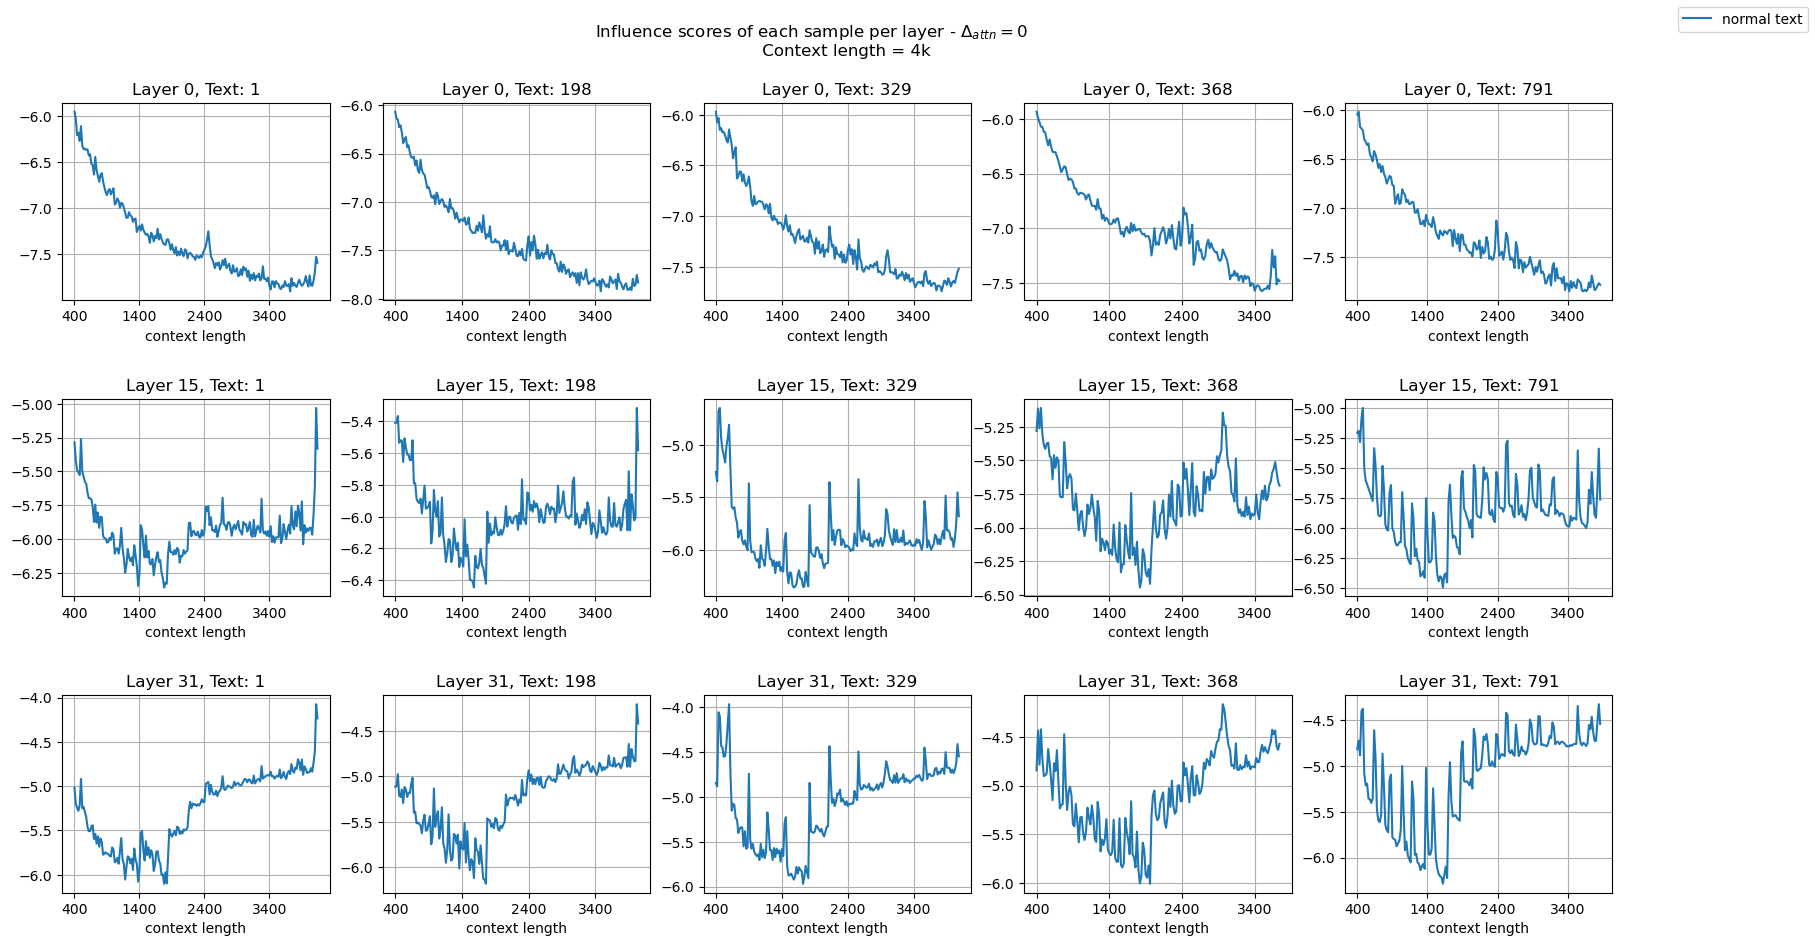

In [15]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(20, 10))

text_id_keymap = {k: i for (i,k) in enumerate(sorted(groupby_text_idx.keys()))}
layer_id_keymap = {0:0, 15: 1, 31: 2}


for text_id, res in pd.DataFrame(groupby_text_idx).T.iterrows():
    for instruction_id in range(len(res)):

        instruction = res.index[instruction_id]
        layers_dict = res.iloc[instruction_id]
        id = text_id_keymap[text_id]

        for layer, influence in layers_dict.items():
            layer_id = layer_id_keymap[layer]

            axes[layer_id][id]\
                .plot(
                    rolling_mean(torch.log(influence), 20)[20:],
                    label = instruction,
                )

            axes[layer_id][id].set_title(f"Layer {layer}, Text: {text_id}")
            axes[layer_id][id].grid(True)

            xticks = axes[layer_id][id].get_xticks()
            new_xticks = xticks * 20 + 400

            # Set the new x-tick labels
            axes[layer_id][id].set_xticklabels(new_xticks.astype(int))
            axes[layer_id][id].set_xlabel("context length")
            # axes[layer_id][id].set_ylim([-10, -5])
handles, labels = axes[-1][-1].get_legend_handles_labels()

fig.suptitle(r'''Influence scores of each sample per layer - $\Delta_{attn} = 0$ 
             Context length = 4k''')


fig.subplots_adjust(top=0.9)
fig.subplots_adjust(hspace=0.5)

fig.legend(handles, labels)


In [39]:
(xticks * 20).astype(int)

array([-1000,     0,  1000,  2000,  3000,  4000])